In [ ]:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [1]:
import pandas as pd
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow

In [2]:
import json
import codecs
import requests
import urllib
import numpy as np
import pandas as pd 
from PIL import Image
from tqdm import tqdm
from io import BytesIO

In [3]:
# get links and stuff from json
jsonData = []
JSONPATH = "./facedetection.json"
with codecs.open(JSONPATH, 'rU', 'utf-8') as js:
    for line in js:
        jsonData.append(json.loads(line))

print(f"{len(jsonData)} image found!")

print("Sample row:")
jsonData[0]

409 image found!
Sample row:


{'annotation': [{'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
  {'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'extras': None}

In [4]:
import torch
import torchvision

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import datasets, DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

In [6]:
# images = []
# for data in tqdm(jsonData):
#     response = requests.get(data['content'])
#     img = np.asarray(Image.open(BytesIO(response.content)))
#     images.append([img, data["annotation"]])


os.makedirs("faces", exist_ok=True)
faces_df = pd.read_json('./facedetection.json', lines=True)

dataset = []


for index,row in tqdm(faces_df.iterrows(), total = faces_df.shape[0]):
    
    img = urllib.request.urlopen(row['content'])
    img = Image.open(img)
    img = img.convert('RGB')
    
    image_name = f'face_{index}.jpeg'    # labeling image
    img.save(f'faces/{image_name}', "JPEG")  # save to dir output kaggle
    
    annotations = row['annotation']
    for i in annotations:
        
        width = i['imageWidth']
        height = i['imageHeight']
        points = i['points']
        
        data = {}
        
        data['file_name'] = image_name
        data['width'] = width
        data['height'] = height
        
        data["x_min"] = int(round(points[0]["x"] * width))
        data["y_min"] = int(round(points[0]["y"] * height))
        data["x_max"] = int(round(points[1]["x"] * width))
        data["y_max"] = int(round(points[1]["y"] * height))
        
        data['class_name'] = 'face'
        
        
        dataset.append(data)

100%|██████████| 409/409 [03:49<00:00,  1.79it/s]


In [7]:
df = pd.DataFrame(dataset)
df

,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,face_0.jpeg,650,333,56,102,112,151,face
1,face_0.jpeg,650,333,379,97,428,156,face
2,face_1.jpeg,1280,697,903,162,985,252,face
3,face_2.jpeg,460,240,216,12,279,80,face
4,face_2.jpeg,460,240,289,2,343,74,face
...,...,...,...,...,...,...,...,...
1127,face_408.jpeg,656,493,164,122,187,150,face
1128,face_408.jpeg,656,493,318,115,346,159,face
1129,face_408.jpeg,656,493,389,156,407,177,face
1130,face_408.jpeg,656,493,507,204,526,226,face


In [8]:
df.to_csv('annotations.csv', header=True, index=None)

In [9]:
import matplotlib.pyplot as plt

DATA_DIR = './faces'
def show_image(image_id):
  temp = df[df['file_name']==image_id]
  img_path = os.path.join(DATA_DIR, image_id)
  image = cv2.imread(img_path, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.
  for idx, row in temp.iterrows():
        
      cv2.rectangle(image, (row.x_min, row.y_min), (row.x_max, row.y_max), (255,255,255), 2)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(image, row.class_name, (row.x_min, (row.y_min - 10)), font, 1, (255,255,255), 2)

  plt.figure(figsize =(20,20))
  plt.imshow(image)
  plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


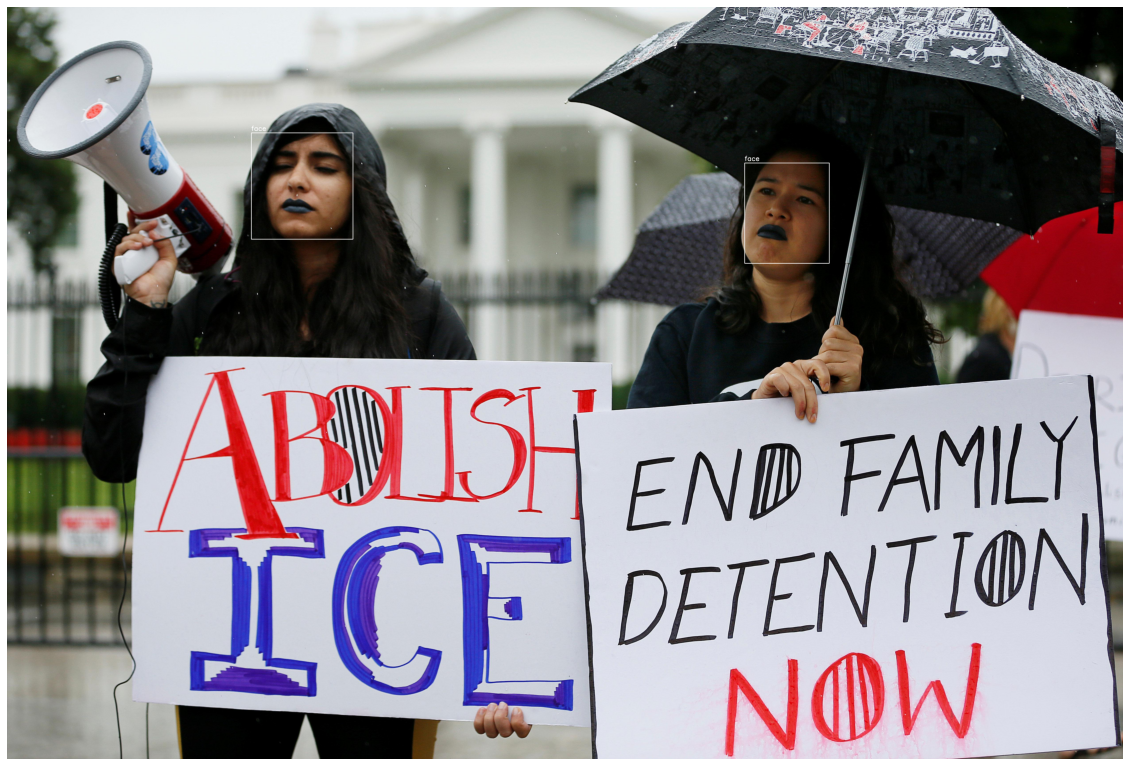

In [10]:
show_image(df.file_name.unique()[16])

In [11]:
unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace = False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]  #negasi
train_files

{'face_0.jpeg',
 'face_1.jpeg',
 'face_10.jpeg',
 'face_100.jpeg',
 'face_101.jpeg',
 'face_102.jpeg',
 'face_103.jpeg',
 'face_104.jpeg',
 'face_106.jpeg',
 'face_107.jpeg',
 'face_108.jpeg',
 'face_109.jpeg',
 'face_11.jpeg',
 'face_110.jpeg',
 'face_111.jpeg',
 'face_112.jpeg',
 'face_113.jpeg',
 'face_114.jpeg',
 'face_115.jpeg',
 'face_116.jpeg',
 'face_117.jpeg',
 'face_118.jpeg',
 'face_119.jpeg',
 'face_12.jpeg',
 'face_120.jpeg',
 'face_121.jpeg',
 'face_122.jpeg',
 'face_123.jpeg',
 'face_124.jpeg',
 'face_125.jpeg',
 'face_126.jpeg',
 'face_127.jpeg',
 'face_128.jpeg',
 'face_129.jpeg',
 'face_13.jpeg',
 'face_130.jpeg',
 'face_131.jpeg',
 'face_132.jpeg',
 'face_133.jpeg',
 'face_134.jpeg',
 'face_135.jpeg',
 'face_136.jpeg',
 'face_137.jpeg',
 'face_138.jpeg',
 'face_139.jpeg',
 'face_14.jpeg',
 'face_140.jpeg',
 'face_141.jpeg',
 'face_142.jpeg',
 'face_143.jpeg',
 'face_144.jpeg',
 'face_145.jpeg',
 'face_146.jpeg',
 'face_147.jpeg',
 'face_148.jpeg',
 'face_149.jpeg',
 

In [16]:
# arr = [31,312,53,2,12,124,432,343]
# for i, x in enumerate(arr):
#   print(i, x)

# import itertools
# xmin, ymin = 0, 0
# xmax, ymax = 10, 10
# poly = [
#   (xmin, ymin), (xmax, ymin),
#   (xmax, ymax), (xmin, ymax)
#   ]

# list(itertools.chain.from_iterable(poly))

In [12]:
import itertools
def create_dataset_dicts(df, classes):
    
    dataset_dicts = []

    for image_id, img_name in enumerate(df.file_name.unique()):
        
        record = {}
        image_df = df[df.file_name == img_name]
        file_path = f'{DATA_DIR}/{img_name}'
        
        record["file_name"] = file_path
        record["image_id"] = image_id
        record["height"] = int(image_df.iloc[0].height)
        record["width"] = int(image_df.iloc[0].width)
        objs = []
        
        for _, row in image_df.iterrows():
            
            xmin = int(row.x_min)
            ymin = int(row.y_min)
            xmax = int(row.x_max)
            ymax = int(row.y_max)
          
            poly = [
              (xmin, ymin), (xmax, ymin),
              (xmax, ymax), (xmin, ymax)
              ]
            
            poly = list(itertools.chain.from_iterable(poly))
            
            
            obj = {
                    "bbox": [xmin, ymin, xmax, ymax],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": classes.index(row.class_name),
                    "iscrowd": 0
                  }
            
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

In [13]:
def register_dataset(df, dataset_label='faces_train', train = True):
    
    # Register dataset - if dataset is already registered, give it a new name    
    try:
        DatasetCatalog.register(dataset_label, lambda d=df: create_dataset_dicts(df, classes))
        MetadataCatalog.get(dataset_label).thing_classes = classes
    except:
        # Add random int to dataset name to not run into 'Already registered' error
        n = random.randint(1, 1000)
        dataset_label = dataset_label + str(n)
        DatasetCatalog.register(dataset_label, lambda d=df: create_dataset_dicts(df, classes))
        MetadataCatalog.get(dataset_label).thing_classes = classes
        
    if train == True:
        
        return MetadataCatalog.get(dataset_label), dataset_label
    
    else:
        
        return dataset_label

In [16]:
import random
classes=['face']
metadata, train_dataset = register_dataset(train_df)

In [17]:
test_dataset = register_dataset(test_df, dataset_label='image_test', train = False)

In [18]:
MODEL_USE = 'retinanet'
if MODEL_USE == 'faster_rcnn':
    MODEL_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
elif MODEL_USE == 'retinanet':
    MODEL_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'

In [19]:
def cfg_setup():
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(WEIGHT_PATH)
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512

    cfg.DATASETS.TRAIN = (train_dataset,)
    cfg.DATASETS.TEST = (test_dataset,)
    cfg.DATALOADER.NUM_WORKERS = 4

    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.001
    cfg.SOLVER.WARMUP_ITERS = 1000
    cfg.SOLVER.MAX_ITER = 500
    cfg.SOLVER.STEPS = (1000, 1500)
    cfg.SOLVER.GAMMA = 0.05
    
    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
    cfg.TEST.EVAL_PERIOD = 500

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        
    return cfg

In [20]:
cfg = cfg_setup()

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [21]:
from detectron2.engine import DefaultTrainer

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/09 18:22:47 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_59f53c.pkl: 228MB [00:23, 9.79MB/s]                           
Unable to load 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model!
Unable to load 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model!


[07/09 18:23:11 d2.engine.train_loop]: Starting training from iteration 0
[07/09 18:23:27 d2.utils.events]:  eta: 0:06:15  iter: 19  total_loss: 2.424  loss_cls: 1.632  loss_box_reg: 0.758  time: 0.7744  data_time: 0.0549  lr: 0.000020  max_mem: 5844M
[07/09 18:23:43 d2.utils.events]:  eta: 0:06:03  iter: 39  total_loss: 1.606  loss_cls: 1.125  loss_box_reg: 0.465  time: 0.7855  data_time: 0.0259  lr: 0.000040  max_mem: 5844M
[07/09 18:23:58 d2.utils.events]:  eta: 0:05:45  iter: 59  total_loss: 1.301  loss_cls: 0.919  loss_box_reg: 0.372  time: 0.7829  data_time: 0.0418  lr: 0.000060  max_mem: 5844M
[07/09 18:24:15 d2.utils.events]:  eta: 0:05:31  iter: 79  total_loss: 1.110  loss_cls: 0.749  loss_box_reg: 0.306  time: 0.7991  data_time: 0.0966  lr: 0.000080  max_mem: 5844M
[07/09 18:24:32 d2.utils.events]:  eta: 0:05:15  iter: 99  total_loss: 0.953  loss_cls: 0.647  loss_box_reg: 0.337  time: 0.8023  data_time: 0.0799  lr: 0.000100  max_mem: 5844M
[07/09 18:24:47 d2.utils.events]:  e

In [22]:
import random
evaluator = COCOEvaluator(test_dataset , cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, test_dataset)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/09 18:37:23 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'image_test'. Trying to convert it to COCO format ...
WARNING [07/09 18:37:23 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/image_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[07/09 18:37:24 d2.data.common]: Serializing 21 elements to byte tensors and concatenating them all ...
[07/09 18:37:24 d2.data.common]: Serialized dataset takes 0.01 MiB
[07/09 18:37:24 d2.evaluation.evaluator]: Start inference on 21 images
[07/09 18:37:26 d2.evaluation.evaluator]: Inference done 11/21. 0.1021 s / img. ETA=0:00:02
[07/09 18:37:27 d2.evaluation.evaluator]: Total inference time: 0:00:02.722579 (0.170161 s / img per device, on 1 devices)
[07/09 18:37:27 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.095286 s / img per device, on 1 devices)
[07/09 18:37:27 d2.evaluation.coco_evaluation]: Pr

OrderedDict([('bbox',
              {'AP': 0.016782991454217466,
               'AP50': 0.07057859559230394,
               'AP75': 0.0,
               'APl': 0.033851408524118755,
               'APm': 0.006377938407337666,
               'APs': nan})])

In [47]:
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'RetinaNet', 'WEIGHTS': './output/model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_retinanet_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775461751, 812.7493386077181]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4'], 'BOUNDARY_THRESH'

In [29]:
def cfg_test():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
    cfg.DATASETS.TEST = (test_dataset,)
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.50
    
    return cfg

cfg = cfg_test()
predict = DefaultPredictor(cfg)

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [35]:
# CONFIG

color = (255, 255, 0)
    
def visual_predict(image, color):
    
    img = cv2.imread('{}/{}'.format(DATA_DIR, image))
    output = predict(img)
    print(output)
    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    v = v.draw_instance_predictions(output['instances'].to('cpu'))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [36]:
test_df.file_name.unique()[0]

'face_39.jpeg'

{'instances': Instances(num_instances=4, image_height=385, image_width=575, fields=[pred_boxes: Boxes(tensor([[298.1868, 118.2353, 409.8617, 256.4518],
        [170.9303,  91.3736, 292.1388, 250.5213],
        [416.0320, 116.9317, 533.6460, 257.2964],
        [ 61.5977,  63.0327, 177.4097, 209.8076]], device='cuda:0')), scores: tensor([0.7521, 0.6947, 0.6430, 0.6097], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])}


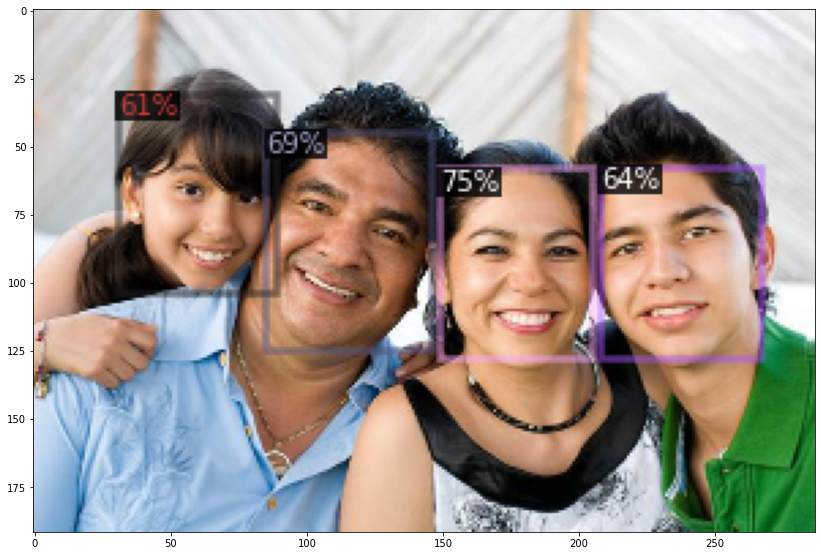

In [38]:
visual_predict(test_df.file_name.unique()[13], color)

In [50]:
!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg

--2020-07-09 19:05:39--  https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg
Resolving www.wsha.org (www.wsha.org)... 104.198.7.33
Connecting to www.wsha.org (www.wsha.org)|104.198.7.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1923610 (1.8M) [image/jpeg]
Saving to: ‘banner-diverse-group-of-people-2.jpg’

banner-diverse-grou 100%[===================>]   1.83M  1.86MB/s    in 1.0s    

2020-07-09 19:05:41 (1.86 MB/s) - ‘banner-diverse-group-of-people-2.jpg’ saved [1923610/1923610]



In [60]:
# img = urllib.request.urlopen('https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg')
img = urllib.request.urlopen('https://www.womensweb.in/wp-content/uploads/2019/05/mother-daughter-movies-header-856x354.png')
img = Image.open(img)
img = img.convert('RGB')

{'instances': Instances(num_instances=9, image_height=354, image_width=856, fields=[pred_boxes: Boxes(tensor([[430.1498, 198.3841, 515.7383, 292.7735],
        [366.4912, 266.6564, 444.8426, 349.7453],
        [610.3448, 198.5962, 691.2106, 294.2310],
        [511.5600,  14.9019, 596.1135, 117.2124],
        [230.2956,  41.0111, 311.4433, 137.7834],
        [709.2039,   5.3731, 783.6898,  77.2533],
        [732.1259, 178.1234, 838.0590, 291.0928],
        [151.7927,   2.7838, 232.4933,  74.7093],
        [174.2919, 241.4601, 261.8054, 343.1303]], device='cuda:0')), scores: tensor([0.7128, 0.6309, 0.6268, 0.6208, 0.5700, 0.5623, 0.5149, 0.5077, 0.5029],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')])}


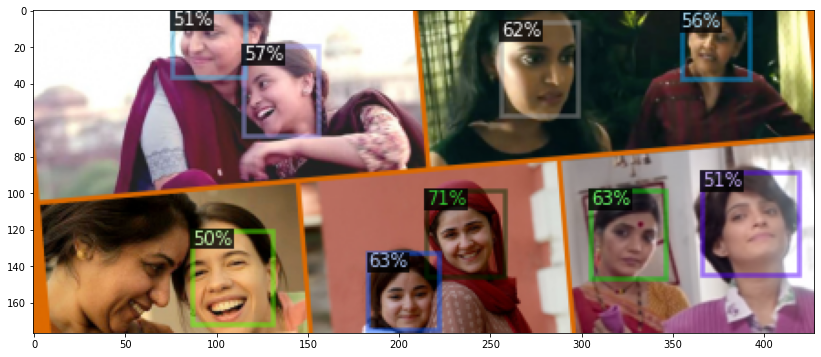

In [61]:
# img = cv2.imread('./people.jpg', cv2.IMREAD_COLOR)
img = np.array(img)
output = predict((img))
print(output)
v = Visualizer(img[:, :, :], metadata=metadata, scale=0.5)
v = v.draw_instance_predictions(output['instances'].to('cpu'))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()